In [1]:
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile
#import mne

# graphical libs
import matplotlib.pyplot as plt
%matplotlib widget
import seaborn as sns

# ml libraries
#from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  LinearRegression, LogisticRegression
from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf
from keras import backend as K
from tensorflow.keras.utils import plot_model

from scipy.signal import savgol_filter #, filtfilt, butter
from collections import deque

#import optuna
#from optuna.samplers import TPESampler

# set number of rows ti display
#pd.set_option("display.max_rows", 9, "display.max_columns", 9)

# lib for interpretator processing
import sys, os
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Hide output
from IPython.display import clear_output
#np.set_printoptions(suppress=True)

# Model serialization
import pickle
import joblib

import serial
import time
import json

In [2]:
# Set requirements
#!pip install -qr ../requirements.txt

In [3]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '../')

from utils.config_reader import config_reader
from utils.functions import read_omg_csv, add_diff, get_mse, preprocessing_0, preprocessing_1, reset_random_seeds, callbacks # 
from utils.figures import get_signals_plot, get_nogo_plot, get_signals_comparison_plot, plot_history, get_nogo, postporocessing_nogo #get_all_sensors_plot, 

# import constants from the config
config = config_reader('../config/data_config.json') 

# path for data
PATH = config.PATH

# path for models
#PATH_MODEL = config.PATH_FOR_MODEL

# if not os.path.exists(PATH_FOR_MODEL):
#     os.mkdir(PATH_FOR_MODEL) 

In [4]:
import random

# Fix seed
seed_value = config.seed_value
os.environ['PYTHONHASHSEED'] = str(seed_value)

# 1. initiate random seed in Python
random.seed(seed_value)

# 2. initiate random seed in Numpy
np.random.seed(seed_value)

# 3. initiate random seed in Optuna
#sampler = TPESampler(seed=seed_value) # fix random seed

# 4. initiate random seed in tensorflow 
tf.random.set_seed(seed_value)
 
# 5. Конфигурация Tenzorflow
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [5]:
# # Reading files with ".npy" and 'csv' extension and saving them to the dictionnary "mounts"
# mounts = dict()

# with ZipFile(os.path.join(PATH, 'data.zip')) as myzip:
#     for file in myzip.namelist():
#             mounts[f"{file[:-4]}".format(file)] = pd.read_csv(myzip.open(file), index_col=0)

# mounts.keys()

In [6]:
palm_file_3_1 = '../data/sprint3_pilote1_mount1_gestures.palm'

gestures_3_1 = read_omg_csv(palm_file_3_1, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

print(gestures_3_1.shape)
display(gestures_3_1.head(3))

# train_test_div_num = int(len(gestures_3_1)*0.8)
# gestures_train_3_1 = gestures_3_1.iloc[:train_test_div_num]
# gestures_test_3_1 = gestures_3_1.iloc[train_test_div_num:]
# print('train :', gestures_train_3_1.shape, 'test: ', gestures_test_3_1.shape)

(19569, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,6,0,7,0,0,12,0,13,20,0,...,57,6,22,27,19,0,0,0,34,980322
1,6,4,1,5,9,2,10,2,13,6,...,28,6,22,27,19,0,0,0,34,980355
2,9,0,4,15,2,8,22,9,10,14,...,7,6,22,27,19,0,0,0,34,980388


In [7]:
palm_file_3_2 = '../data/sprint3_pilote1_mount2_gestures.palm'
gestures_3_2 = read_omg_csv(palm_file_3_2, 
                        n_omg_channels=50,
                        n_acc_channels=3, 
                        n_gyr_channels=3, 
                        n_enc_channels=6, 
                        n_mag_channels=0)

print(gestures_3_2.shape)
display(gestures_3_2.head(3))

# train_test_div_num = int(len(gestures_3_2)*0.8)
# gestures_train_3_2 = gestures_3_2.iloc[:train_test_div_num]
# gestures_test_3_2 = gestures_3_2.iloc[train_test_div_num:]
# print('train: ' ,gestures_train_3_2.shape, 'test: ', gestures_test_3_2.shape)

(19628, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,9,8,0,2,22,10,4,6,7,28,...,5,17,27,38,34,11,0,0,0,253431
1,4,11,0,16,0,9,1,5,16,0,...,3,17,27,38,34,11,0,0,0,253464
2,8,9,4,0,4,22,4,5,16,0,...,-1,17,27,38,34,11,0,0,0,253497


### Gestures train and test

In [8]:
# Обозначение колонок для удобства доступа
# [X features] '0', ..., '49' - каналы OMG датчиков
OMG_CH = [str(i) for i in range(50)]

# 'ACC0', 'ACC1', 'ACC2' - акселерометр 
ACC_CH = config.ACC_CH

# 'GYR0', 'GYR1', 'GYR2' - гироскоп
GYR_CH = config.GYR_CH

# [y target] = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5'] - координаты пальцев в перчатке GLOVE
GLOVE_CH = config.GLOVE_CH[:-1] # Датчик 'ENC5' не используем

# 'BUTTON' - не используется
BUTTON_SYNC_TS_CH = config.BUTTON_SYNC_TS_CH

# Обозначение признаков разницы
col_diff_names = [x + '_DIFF' for x in OMG_CH]
COLS = OMG_CH + col_diff_names

# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времен

# assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_3_1.shape[-1]
# assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_3_2.shape[-1]

print(f"OMG_CH: {OMG_CH}")
print(f"ACC_CH: {ACC_CH}")
print(f"GYR_CH: {GYR_CH}")
print(f"GLOVE_CH: {GLOVE_CH}")
print(f"BUTTON_SYNC_TS_CH: {BUTTON_SYNC_TS_CH}")

#print(gestures_train.shape, gestures_test.shape, mounts['gestures_train_2'].shape, mounts['gestures_test_2'].shape)

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


```Python
# Обозначения
[X features] '0', ..., '49' - каналы OMG датчиков
             'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
[y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
'BUTTON' - не используется
'SYNC' - синхронизация данных с протоколом
'ts' - метка времен
```

### Dataset concatenation

In [9]:
gestures = pd.concat([gestures_3_1, gestures_3_2], axis=0).reset_index(drop=True)
gestures.shape

(39197, 65)

## Composition of X_train

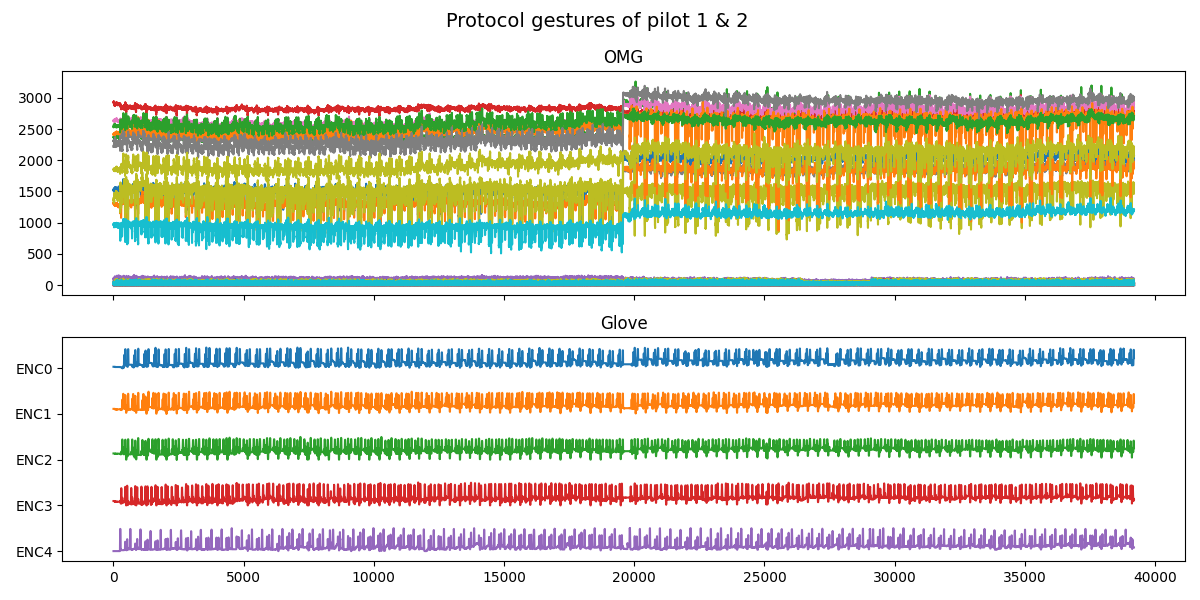

In [10]:
get_signals_plot(gestures[OMG_CH], gestures[GLOVE_CH], title='Protocol gestures of pilot 1 & 2 ')

In [11]:
# Scaling values
scaler = MinMaxScaler(feature_range=(0, 1))
X, y = scaler.fit_transform(gestures[OMG_CH].values), gestures[GLOVE_CH].values/100 

joblib.dump(scaler, os.path.join(config.PATH_MODEL, "MinMax_scaler"+'.bin'), compress=True) 
print('X: ', X.shape, 'y: ', y.shape)

X:  (39197, 50) y:  (39197, 5)


In [12]:
# # Split data by 3 samples: train, test and valid
# X_train, X_test, y_train, y_test= train_test_split(X, y, shuffle=False, test_size=0.2,  random_state=seed_value)
# #X_test, X_valid, y_test, y_valid  = train_test_split(X_test, y_test, test_size=0.5, random_state=seed_value)

# # Check samples shapes
# print('Train shape: {}'.format(X_train.shape))
# print('Test shape:  {}'.format(X_test.shape))
# #print('Valid shape: {}'.format(X_valid.shape))

In [13]:
train_test = int(len(X)*0.8)
X_train, y_train = X[:train_test], y[:train_test] # ~80% train
X_test, y_test = X[train_test:], y[train_test:] # ~20% test
print('X_train', X_train.shape, 'X_test', X_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

X_train (31357, 50) X_test (7840, 50)
y_train (31357, 5) y_test (7840, 5)


In [14]:
# X_train_1, X_test_1 = gestures_train[OMG_CH].values, gestures_test[OMG_CH].values #56
# # Предобработка скользящим окном
# #X_train, X_test = X_train.rolling(window=3).mean().dropna(axis=0), X_test.rolling(window=3).mean().dropna(axis=0)

# display('X_train', pd.DataFrame(X_train_1, columns=OMG_CH).head(2))

# y_train_1, y_test_1 = gestures_train[GLOVE_CH].values, gestures_test[GLOVE_CH].values

# # Предобработка скользящим окном
# #y_train, y_test =  y_train.iloc[2:,:], y_test.iloc[2:,]
# display('y_train', pd.DataFrame(y_train_1, columns=GLOVE_CH).head(2) )#'y_test', y_test.head(2)

In [15]:
# dist = -np.arange(3) * 300
# dist1 = -np.arange(5)* 200
# dist2 = -np.arange(3) * 1000

# fig, ax = plt.subplots(4, 1, sharex=True, figsize=(12, 8)) # plt.sca(axes)
# ax[0].plot(y_train+dist1)
# ax[0].set_title('Target')
# ax[0].yaxis.set_ticks(dist1, GLOVE_CH)

# ax[1].plot(X_train_prn)
# ax[1].set_title('Pronation')
# ax[1].yaxis.set_ticks(np.linspace(0,1,3), ['position_1', 'position_2', 'position_3'])

# ax[2].plot(X_train_acc+dist)
# ax[2].yaxis.set_ticks(dist, ACC_CH)
# ax[2].legend(ACC_CH, bbox_to_anchor=(1, 0.7))
# ax[2].set_title('Accelerators')

# ax[3].plot(X_train_gyr + dist2)
# ax[3].set_title('Hyroscopes')
# ax[3].legend(GYR_CH, bbox_to_anchor=(1, 0.7));

# #plt.show()

# #gestures_train[ACC_CH].head(2)

In [16]:
# Pronat = pd.get_dummies(gestures_protocol['Pronation'], prefix='Pronation')
# gestures_protocol = pd.concat([gestures_protocol, Pronat], axis=1)
# gestures_protocol.drop(['Pronation'], axis=1, inplace=True)

# # Features list
# PRON = ['Pronation_0.0', 'Pronation_0.5', 'Pronation_1.0']

# gestures_protocol.head(2)

In [17]:
# # Проверка есть ли отрицательные скорости в датасете
# mask = mounts['gestures_train']['ACC0'] < 0
# mounts['gestures_train'][mask][ACC_CH].head(2)

# Preprocessing

In [18]:
# fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# dist = - np.arange(5) * 200
# plt.plot(y_train + dist)
# ax.yaxis.set_ticks(dist, labels=GLOVE_CH)

# plt.suptitle('Signals smoothing')
# plt.grid()

In [19]:
# # Smoothing of sensor 0 signal
# temp = pd.DataFrame({
#     'original':X_train_raw[:1000,3], 
#     'Savitsky golay filter':np.round(X_train[:1000,3]), 
#     #'digital filter':X_train.iloc[:,0]
# })

# fig, ax = plt.subplots(1, 1, figsize=(12, 4))
# sns.lineplot(temp)
# plt.suptitle('Signals smoothing')
# plt.grid()

In [20]:
# Add differential values
# X_train, X_test  = add_diff(X_train, shift_=5), add_diff(X_test, shift_=5) #, X_free, add_diff(X_free_raw, shift_=5)

In [21]:
# # Smoothing of sensor signals
# X_gest = np.transpose([savgol_filter(X_train[:,i], window_length=5, polyorder=2) for i in range(X_train.shape[1])]) 
# X_test = np.transpose([savgol_filter(X_test[:,i], window_length=5, polyorder=2) for i in range(X_test.shape[1])])

In [22]:
# # Read config
# with open('../config/data_config.json', mode='r', encoding='utf-8') as config_file:
#     cfg = json.load(config_file)
    
#     # add new entrie
#     cfg.update(scaler_name="MinMax_scaler.bin")

# # write config
# with open('../config/data_config.json', mode='w') as f:   
#     f.write(json.dumps(cfg, indent=2))

## NOGO

In [23]:
#get_nogo_plot(y_train, (25000, 28970))

In [24]:
# # Concatenation of 2 pilots' accelerators data 
# X_train_ac_1, X_test_ac_1 = mounts['gestures_train'][ACC_CH].values, mounts['gestures_test'][ACC_CH].values
# X_train_ac_2, X_test_ac_2 = mounts['gestures_train_2'][ACC_CH].values, mounts['gestures_test_2'][ACC_CH].values
# X_free_ac_1, X_free_ac_2 = mounts['free_movements'][ACC_CH].values, mounts['free_movements_2'][ACC_CH].values

# #X_train_ag, X_test_ag, X_free_ag = np.concatenate((X_train_ag_1, X_train_ag_2), axis=0), np.concatenate((X_test_ag_1, X_test_ag_2), axis=0), np.concatenate((X_free_ag_1, X_free_ag_2), axis=0)

# X_train_ac = np.concatenate((X_train_ac_1, X_test_ac_1, X_train_ac_2, X_test_ac_2, X_free_ac_1, X_free_ac_2), axis=0)[1:]
# X_train_ac.shape

In [25]:
# y_train_ac_1, y_test_ac_1 = mounts['gestures_train'][GLOVE_CH].values, mounts['gestures_test'][GLOVE_CH].values
# y_train_ac_2, y_test_ac_2 = mounts['gestures_train_2'][GLOVE_CH].values, mounts['gestures_test_2'][GLOVE_CH].values
# y_free_ac_1, y_free_ac_2 = mounts['free_movements'][GLOVE_CH].values, mounts['free_movements_2'][GLOVE_CH].values

# y_train_ac = np.concatenate((y_train_ac_1, y_test_ac_1, y_train_ac_2, y_test_ac_2, y_free_ac_1, y_free_ac_2), axis=0)
# y_train_ac.shape

In [26]:
#X_gest.shape

In [27]:
# y_train_nogo = postporocessing_nogo(get_nogo(y_train))

# # add zero element in the beginning to match shape with X_train
# y_gest_nogo = np.concatenate((np.zeros(1), y_train_nogo),axis=0) 
# y_gest_nogo.shape

In [28]:
# #y_train_post, y_test_post, y_free_post = postporocessing_nogo(get_nogo(y_train)), postporocessing_nogo(get_nogo(y_test)), postporocessing_nogo(get_nogo(y_free_raw))

# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train_ac_scaled = scaler.fit_transform(X_train_ac)
# X_train_ac_scaled.shape
# #y_train, y_test = np.c_[y_train_ag, np.r_[np.zeros(1), y_train_ag]], np.c_[y_test_ag, np.r_[np.zeros(1), y_test_ag]]
# #y_train_ag, y_test_ag, y_free_ag = np.r_[np.zeros(1), y_train_post], np.r_[np.zeros(1), y_test_post], np.r_[np.zeros(1), y_free_post]

# # Shape : (50296, 50)
# #X_train_raw.shape 

In [29]:
#get_nogo_plot(y_free_raw, (0, 17500))

In [30]:
# temp = pd.DataFrame({'nogo':y_gest_nogo})
# fig_id = 1

# fig, ax = plt.subplots(figsize=(3, 3)) 
# sns.countplot(data=temp, x='nogo', width=0.5)
# ax.set_title(f'Fig.{fig_id} - Target classes balance', y=-0.4, loc='right');
# plt.tight_layout();


In [31]:
# X, y = X_gest.copy(), y_gest_nogo.copy()

# # Split data by 3 samples: train, test and valid
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  random_state=seed_value)
# X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=seed_value)

# # Check samples shapes
# print('Train shape: {}'.format(X_train.shape))
# print('Test shape:  {}'.format(X_test.shape))
# print('Valid shape: {}'.format(X_valid.shape))

In [32]:

# #X_test_ag, X_valid_ag, y_test_ag, y_valid_ag  = train_test_split(X_test_ag, y_test_ag, test_size=0.5, random_state=seed_value)

# log_reg = LogisticRegression(
#     #solver='sag', 
#     max_iter=300,
#     random_state=seed_value)

# # Model training
# log_reg.fit(X_train, y_train) 

# # Prediction of target values
# y_pred_nogo = log_reg.predict(X_test)

# # Metrics report
# print(classification_report(y_test, y_pred_nogo))

In [33]:
# X, y = X_gest.copy(), y_gest_nogo.copy()
# print(X.shape, y.shape)

In [34]:
# from imblearn.over_sampling import SMOTE

# # Synthetic resampling of minority class
# sm = SMOTE(random_state=seed_value)
# X, y = sm.fit_resample(X, y)

# unique, counts = np.unique(y, return_counts=True)
# print('After synthetic resampling : ',unique, counts)

In [35]:
# # Split data by 3 samples: train, test and valid
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,  random_state=seed_value)
# X_test, X_valid, y_test, y_valid  = train_test_split(X_valid, y_valid, test_size=0.5, random_state=seed_value)

# # Check samples shapes
# print('Train shape: {}'.format(X_train.shape))
# print('Test shape:  {}'.format(X_test.shape))
# print('Valid shape: {}'.format(X_valid.shape))

In [36]:
# # Prediction of nogo using resampled data
# log_reg = LogisticRegression(
#     #solver='sag', 
#     max_iter=300,
#     random_state=seed_value)

# # Model training
# log_reg.fit(X_train, y_train) 

# # Prediction of target values
# y_pred_nogo = log_reg.predict(X_test)

# # Metrics report
# print(classification_report(y_test, y_pred_nogo))

In [37]:
# # Save model to the given path in the pkl format
# model_name = 'log_reg'
# full_path = os.path.join(config.PATH_MODEL, model_name + '.pkl')  
 
# with open(full_path, 'wb') as f:
#     pickle.dump(log_reg, f)

In [38]:
# # Prediction of free_movements values
# y_pred1 = log_reg.predict(X_free_ag)
# # Metrics report
# print(classification_report(y_free_ag, y_pred1))

# Modeling

In [39]:
duration = 60
ts_events = np.arange(0, len(X_train), 10)

X_train_nn = [X_train[ts_event : ts_event + duration] for ts_event in ts_events]
y_train_nn = [y_train[ts_event : ts_event + duration] for ts_event in ts_events]

X_train_nn = np.array([arr for arr in X_train_nn if arr.shape == X_train_nn[0].shape])
y_train_nn = np.array([arr for arr in y_train_nn if arr.shape == y_train_nn[0].shape])

print(X_train_nn.shape, y_train_nn.shape)

(3130, 60, 50) (3130, 60, 5)


In [40]:
X_test_nn = [X_test[ts_event : ts_event + duration] for ts_event in ts_events]
y_test_nn = [y_test[ts_event : ts_event + duration] for ts_event in ts_events]

X_test_nn = np.array([arr for arr in X_test_nn if arr.shape == X_test_nn[0].shape])
y_test_nn = np.array([arr for arr in y_test_nn if arr.shape == y_test_nn[0].shape])

print(X_test_nn.shape, y_test_nn.shape)

(779, 60, 50) (779, 60, 5)


In [41]:
reset_random_seeds(seed_value)

#np.expand_dims(X_train, axis=0).shape

n_timesteps = None
#b_size = 64
n_channels = X_train_nn.shape[-1] # gestures_train[[*OMG_CH, *ACC_CH, *GYR_CH]].shape[1] 
output_units = y_train_nn.shape[-1]

# model architecture
input_layer = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LSTM(units=100, 
                         #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-3),
                         return_sequences=True,
                         )(x) 
x = tf.keras.layers.Dropout(0.5)(x) #0.3

output_layer = tf.keras.layers.Dense(units=output_units, activation='elu')(x)

model = tf.keras.Model(
    inputs=input_layer,
    outputs=output_layer,
    name="model_LSTM"
    )

model.summary()

tf.keras.backend.clear_session()

reset_random_seeds(seed_value)

model.compile(
    loss="mean_squared_error", 
    metrics=['mse'], 
    optimizer=tf.keras.optimizers.experimental.AdamW(learning_rate=0.001) #learning_rate=0.001
    )

callbacks_list = callbacks(1e-03, 'LSTM-60-10') #

Model: "model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 50)]        0         
                                                                 
 batch_normalization (BatchN  (None, None, 50)         200       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, None, 100)         60400     
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 dense (Dense)               (None, None, 5)           505       
                                                                 
Total params: 61,105
Trainable params: 61,005
Non-trainable params: 100
__________________________________________________

In [ ]:
history = model.fit(
    X_train_nn,
    y_train_nn, 
    epochs=500,
    validation_split=0.2,
    verbose=1,
    callbacks=callbacks(1e-04, 'LSTM-60-10')
)

clear_output(False)
#y_pred_train_nn = model.predict(X_train_nn)
#print(y_pred_train_nn.shape)

In [ ]:
#plot_model(model)

In [ ]:
# Save LSTM model
#model.save(os.path.join(config.PATH_MODEL, model.name))

In [ ]:
plot_history(history, model.name)

### Prediction

In [43]:
# Loanding saved model
model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'LSTM-60-10.hdf5'))

y_pred_test = np.round(model.predict(X_test[None, :])[0]*100)
y_pred_train = np.round(model.predict(X_train[None, :])[0]*100)


get_mse(y_test, y_pred_test)
get_mse(y_train, y_pred_train)
# y_test_true = y_test*100

# metrics_test = np.array([mean_squared_error(y_test_true[:, col], y_pred_test[:, col]) for col in range(len(GLOVE_CH))])

# display(pd.DataFrame({'Test':metrics_test}, index=GLOVE_CH)) 

1/1 [==============================] - 2s 2s/step


,Test
ENC0,139.800255
ENC1,141.276786
ENC2,127.456122
ENC3,141.326020
ENC4,250.475255


,Test
ENC0,41.598208
ENC1,39.126224
ENC2,39.403132
ENC3,50.118793
ENC4,69.437287


In [61]:
# Display comparison plot
#get_signals_comparison_plot(y_train*100, y_test*100, y_pred_test, only_test=True)


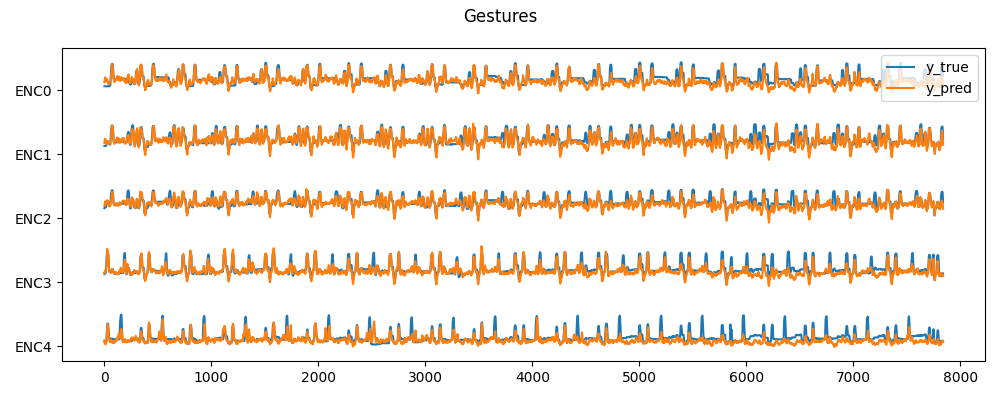

In [47]:
y_pred = y_pred_test
y_test1 = y_test*100

fig, axes = plt.subplots(1, 1, figsize=(10, 4)) 
 
# Слагаемые для разделения показаний датчиков
yticks = np.arange(len(GLOVE_CH)) * 200
lines, labels = [], []
indexes = np.arange(y_test1.shape[0])

p = plt.plot(indexes, np.subtract(y_test1, yticks), c='C0') #
lines += [p[0]]
labels += ['y_true']

 
p = plt.plot(indexes, np.subtract(y_pred, yticks), c='C1', linestyle='-')
lines += [p[0]]
labels += ['y_pred']
 

plt.yticks(-yticks, GLOVE_CH)
plt.legend(lines, labels)
plt.suptitle(f'Gestures')
plt.tight_layout()
plt.show()

# Работает до этого места
---

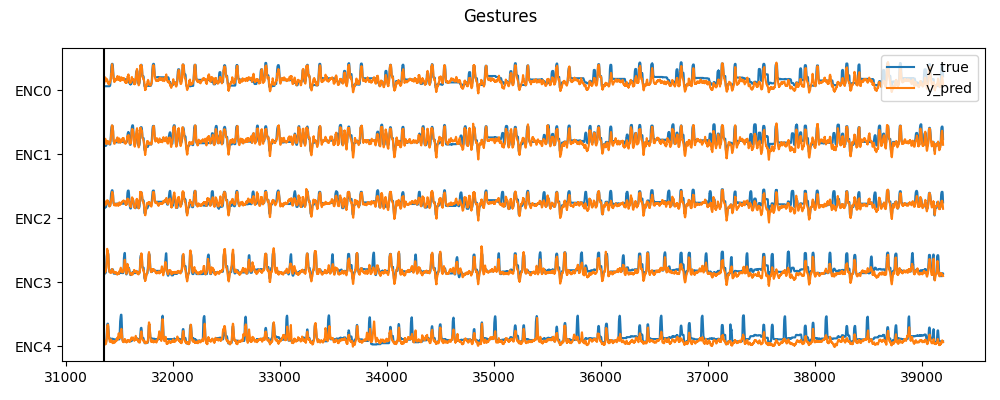

In [62]:
# Display comparison plot
get_signals_comparison_plot(y_train*100, y_test*100, y_pred_test, only_test=True)

### LSTM с разбивкой

In [ ]:
# Train------------------------------------
# X_train = gestures_train[OMG_CH].values

# diff_1_train = add_diff(X_train, 1)

# X_train = np.hstack([X_train,
#                      diff_1_train,
#                     ])

# X_train = scaler.transform(X_train)

# y_train_true = gestures_train[GLOVE_CH]

# # Test------------------------------------
# gestures_test = pd.concat([gestures_test_2_1, gestures_test_2_2]).reset_index(drop=True)

# X_test = gestures_test[OMG_CH].values
# diff_1_test = add_diff(X_test, 1)

# # X_test = np.hstack([X_test,
# #                     diff_1_test,
# #                    ])

# X_test = scaler.transform(X_test)
# y_pred_test = model.predict(X_test[None, :])[0]*100
# y_pred_test = pd.DataFrame(y_pred_test, columns=GLOVE_CH, index=gestures_test.index)

# y_test_true = gestures_test[GLOVE_CH]


# y_pred_train = model.predict(X_train[None, :])[0]*100
# print(y_pred_train.shape)

# y_pred_train = pd.DataFrame(y_pred_train, columns=GLOVE_CH, index=gestures_train.index)


402/402 [==============================] - 1s 2ms/step


,Test
ENC0,161.596508
ENC1,115.613151
ENC2,128.160472
ENC3,194.340365
ENC4,299.623376


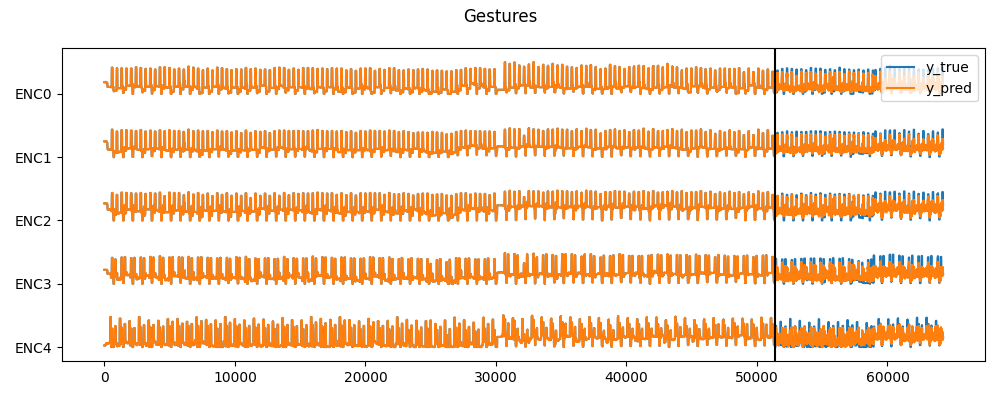

In [71]:
# Loanding saved model
model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'LSTM_splitted'+ '.hdf5'))

#y_pred_train = model.predict(np.expand_dims(X_train, 1)) 
y_pred_test = model.predict(np.expand_dims(X_test, 1)) # 

# Display metrics
get_mse(y_test, y_pred_test.reshape((12852, 5)))

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred_test.reshape(12852, 5), only_test=1)

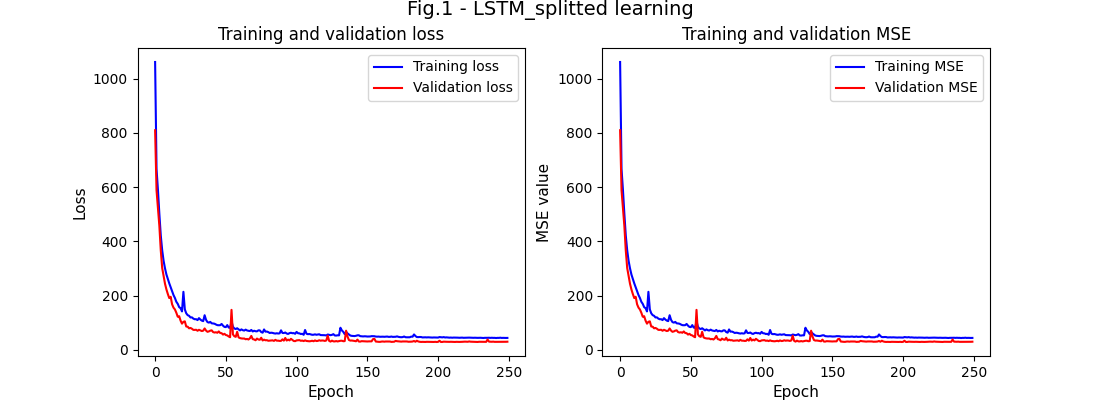

In [59]:
plot_history(history_splitted , model.name)

### Model_stateful

In [62]:

# model  for inference
n_channels = X_train.shape[1]
n_timesteps = None

output_units = y_train.shape[1]
hidden_size = 100

model_input = tf.keras.Input(batch_shape=(1, 1, n_channels))

x = tf.keras.layers.BatchNormalization()(model_input)

x = tf.keras.layers.LSTM(
    units=hidden_size,
    return_sequences=True,
    #recurrent_regularizer=tf.keras.regularizers.L1L2(l1=1e-3, l2=1e-2),
    # return_state=True,
    # last state for each sample at index i in a batch will be used 
    # as initial state for the sample of index i in the following batch
    stateful=True,
    # speed-up a RNN, but more memory-intensive.
    # only suitable for short sequences.
    unroll=True
)(x)

#x = tf.keras.layers.Dropout(0.3)(x)

model_output = tf.keras.layers.TimeDistributed(
    tf.keras.layers.Dense(
        units=output_units,
        activation='relu',
    ),
)(x)

model_stateful = tf.keras.Model(
    inputs=[model_input],
    outputs=[model_output],
    name='model_stateful'
)

# # Загрузка модели из памяти
model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))

# Загрузка весов из памяти
#model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'best_model.hdf5'))

model_stateful.set_weights(model.get_weights())

model_stateful.summary()

Model: "model_stateful"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(1, 1, 100)]             0         
                                                                 
 batch_normalization_3 (Batc  (1, 1, 100)              400       
 hNormalization)                                                 
                                                                 
 lstm_3 (LSTM)               (1, 1, 100)               80400     
                                                                 
 time_distributed_3 (TimeDis  (1, 1, 5)                505       
 tributed)                                                       
                                                                 
Total params: 81,305
Trainable params: 81,105
Non-trainable params: 200
_________________________________________________________________


In [215]:
# Test single prediction on the real data entry after MinMaxScaler
check_data = X_train[430]#.copy()

check_data = np.expand_dims(np.expand_dims(check_data, 0), 0)
print('after reshaping:', check_data.shape) # after reshaping: (1, 1, 100)

#y_pred = model_stateful(check_data, training=False)#.round(2)
y_pred = model_stateful.predict(check_data).round()
print(y_pred.shape)
y_pred[0][0]

after reshaping: (1, 1, 100)
1/1 [==============================] - 0s 21ms/step
(1, 1, 5)


array([ 8., 21., 37., 61., 68.], dtype=float32)

In [176]:
# # Считает более 12 минут!
# #
# #
# #

# check_data = X_test[420:450].copy()
# y_pred_stateful = []
# #ss = list()
# #check_data = np.expand_dims(np.expand_dims(check_data, 0), 0)

# for i in range(check_data.shape[0]):
#     x = np.expand_dims(np.expand_dims(check_data[i,:], 0), 0)
#     #ss.append(x)
#     y_pred = model_stateful.predict(x).round()
#     y_pred_stateful.append(y_pred[0][0])#
    
#     #y_pred = model_stateful(x, training=False)
#     #y_pred_stateful.append(y_pred.numpy()[0][0])#

# y_pred_stateful = np.vstack(y_pred_stateful)#[0][0]
# clear_output(wait=False)

# y_pred_stateful.shape

(12574, 5)

In [ ]:
check_data = X_test[420:450].copy()
y_pred_stateful = []

#check_data = np.expand_dims(np.expand_dims(check_data, 0), 0)

for i in range(check_data.shape[0]):
    x = np.expand_dims(np.expand_dims(check_data[i,:], 0), 0)
    y_pred = model_stateful.predict(x).round()
    y_pred_stateful.append(y_pred[0][0])#
    
    #y_pred = model_stateful(x, training=False)
    #y_pred_stateful.append(y_pred.numpy()[0][0])#

y_pred_stateful = np.vstack(y_pred_stateful)#[0][0]
clear_output(wait=False)

,Test
ENC0,148.877764
ENC1,142.594481
ENC2,201.230476
ENC3,216.923334
ENC4,262.127008


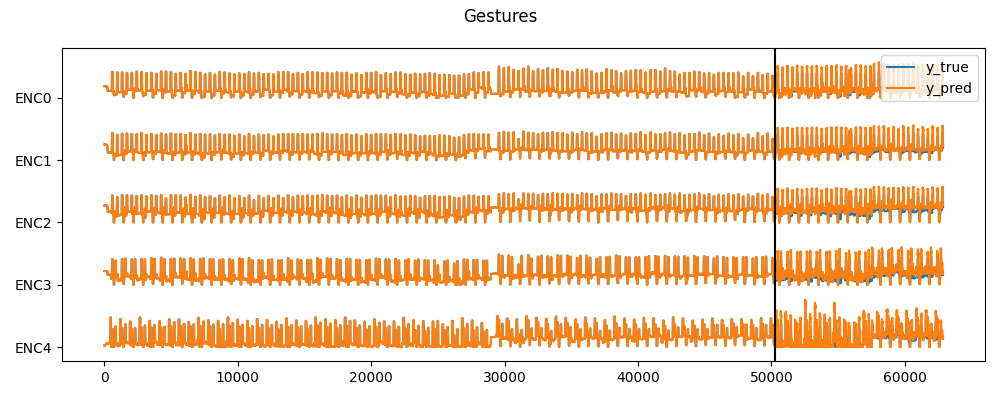

In [177]:
# Display metrics
get_mse(y_test, y_pred_stateful)

# Display comparison plot
get_signals_comparison_plot(y_train, y_test, y_pred_stateful, only_test=1)

In [178]:
preproc_coef = 0.57
prev = None

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

y_pred = y_pred_stateful
# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred)
y_pred_test_proc[0] = y_pred[0]


for i in range(1, len(y_pred)):
    y_pred_test_proc[i] = postprocessing(y_pred[i], y_pred[i-1])

# округление
#y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH]).round() # или np.rint()

# преобразование значений в заданный диапазон 
y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100)) 

# Display metrics
get_mse(y_test, y_pred_test_proc)

,Test
ENC0,140.082551
ENC1,130.555909
ENC2,171.523382
ENC3,186.913075
ENC4,224.189200


In [ ]:

# real data
check_data = X_train[:10000]#.copy()
check_data = np.expand_dims(check_data, 0)
len_check_data = check_data.shape[1]

# predict by model.predict
y_pred = model.predict(check_data)
print(y_pred.shape)


model_stateful.reset_states()
y_pred_stateful = []
for i in range(check_data.shape[1]):
    embedding_stateful = model_stateful(check_data[:, [i]], training=False)
    y_pred_stateful.append(embedding_stateful.numpy())
 
y_pred_stateful = np.hstack(y_pred_stateful)

# CHECK equality of predictions
# ALL
print(np.allclose(y_pred, y_pred_stateful, atol=0.000001))

# EACH ONE
np.isclose(y_pred, y_pred_stateful).sum() / np.prod(y_pred_stateful.shape)

In [ ]:
%%time

model_stateful.reset_states()

y_pred_stateful = []

time_start = time.time()

for i in range(check_data.shape[1]):
    embedding_stateful = model_stateful(check_data[:, [i]], training=False)
    y_pred_stateful.append(embedding_stateful.numpy())
    
time_end = time.time()
ts = (time_end - time_start) / len_check_data
    
y_pred_stateful = np.hstack(y_pred_stateful)

print(f"Avg time of {len_check_data} iters: {ts:.4f}")
print(y_pred_stateful.shape)
# y_pred_stateful[:, :10]

## Postprocessing

In [70]:
preproc_coef = 0.57

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    return y

# пропускаем нулевой элемент
y_pred_test_proc = np.zeros_like(y_pred_test)
y_pred_test_proc[0] = y_pred_test[0]


for i in range(1, len(y_pred_test)):
    y_pred_test_proc[i] = postprocessing(y_pred_test[i], y_pred_test[i-1])

# округление
#y_pred_test_proc = pd.DataFrame(y_pred_test_proc, columns = [GLOVE_CH]).round() # или np.rint()

# преобразование значений в заданный диапазон 
y_pred_test_proc = np.round(np.clip(y_pred_test_proc, 0, 100)) 

# Display metrics
get_mse(y_test, y_pred_test_proc.reshape(12852, 5))

,Test
ENC0,157.995331
ENC1,112.255680
ENC2,124.305322
ENC3,190.669546
ENC4,293.343760


# Дальше не готово 
---

In [63]:
y_test[:5]

array([[ 6, 19, 18, 12,  0],
       [ 6, 19, 18, 12,  0],
       [ 6, 19, 18, 12,  0],
       [ 6, 19, 18, 12,  0],
       [ 6, 19, 18, 12,  0]], dtype=int64)

In [64]:
y_pred_test_proc[:5]

array([[[17., 23., 26., 21., 15.]],

       [[17., 22., 26., 21., 16.]],

       [[16., 21., 24., 20., 15.]],

       [[12., 17., 20., 15., 10.]],

       [[14., 19., 22., 18., 14.]]], dtype=float32)

In [ ]:
x_previous = np.zeros(5)

def commands_new(x:np.array, x_previous:np.array, sample_preprocessed:np.array, model=log_reg):
    """Add nogo to commands

    Args:
        x (np.array): current postprocessed prediction
        x_previous(np.array): previous postprocessed prediction
        sample_preprocessed (np.array) - preprocessed raw vector
        
        model (_type_, optional): _description_. Defaults to log_reg.

    Returns:
        _type_: _description_
    """    
    #if model.__class__ == LogisticRegression:
    nogo_predicted = log_reg.predict(sample_preprocessed.reshape(1,-1))[0]
        
    if nogo_predicted == 0:
        
        return x_previous
    
    else:
        return np.round(x).astype(int) #np.round(np.clip(x, 0, 100)).astype(int)

x_previous = np.array([20., 27., 32., 21., 12.])

x = y_pred_test_proc

for i in range(1, len(x)):
    y_commands          = commands_new(x, x_previous, sample_preprocessed, model=log_reg)  
    
    
    y_pred_test_proc[i] = commands_new(y_pred_test[i], y_pred_test[i-1])
    

In [179]:
temp = pd.DataFrame({ 
    'manual reg':[125.031334, 88.158184, 96.358915, 127.938842, 260.210514],
    'lin_reg':[123.405281, 88.063544, 94.860267, 124.825990, 259.966598], #Lin+add_diff+Savgol
    'XGB model':[116.951579, 65.054954, 60.484251, 57.038965, 160.077521],
    'LSTM': [46.853905, 22.026404, 29.556625, 38.857245, 97.399873],
    'model_stateful': [140.082551, 130.555909, 171.523382, 186.913075, 224.189200] 
}, index=['ENC0','ENC1','ENC2','ENC3','ENC4']) #, index=GLOVE_CH 

temp.round()

,manual reg,lin_reg,XGB model,LSTM,model_stateful
ENC0,125.0,123.0,117.0,47.0,140.0
ENC1,88.0,88.0,65.0,22.0,131.0
ENC2,96.0,95.0,60.0,30.0,172.0
ENC3,128.0,125.0,57.0,39.0,187.0
ENC4,260.0,260.0,160.0,97.0,224.0


# Real-time inference

In [52]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils

In [147]:
df_sim = mounts['gestures_train'].copy()#.iloc[:10000]
df_sim = df_sim.values[450:461,:50].astype(np.int16)
df_sim.shape

# Возьмем элемент 460 для наглядности
x = df_sim[-1,:]
x

array([   5,    6,   13, 2237, 2417, 2740, 2535,   22,    8,    6,    9,
         23, 1296, 1449,   38,   44, 2497, 2844,   28,    5,    4, 1551,
       1101,   36,    9,    7,   30, 1683, 1007,   14, 1163,  638,   22,
         10,    5,    4,    9,   42, 1434, 1503,   32,   28,    0,   11,
          7,    6,    9,   14,   33,   28], dtype=int16)

In [148]:
# Scaling
scaler = joblib.load(os.path.join(config.PATH_MODEL, config.scaler_name))

# Empty buffer for data
buff = np.zeros((5,50))
 

def preprocessing(x:np.array, buff:np.array=buff,  scaler=scaler):
    
    buff[0], buff[1], buff[2], buff[3] = buff[1], buff[2], buff[3], buff[4]
    
    #x - sample vector
    x_scaled = scaler.transform(x.reshape(1,-1))[0]
    
    buff[4] =  x_scaled 
    
    y = np.hstack([x_scaled, buff[4]- buff[3]])
    
    buff = np.transpose([savgol_filter(buff[:,i], window_length=5, polyorder=2, axis=0) for i in range(buff.shape[1])])[:,:5]
    
    return y, buff 

In [150]:
for i in range(df_sim.shape[0]):
    y, buff = preprocessing(df_sim[i])
    
y, buff = preprocessing(df_sim[-1])
y_1, buff = preprocessing(df_sim[-2])

In [151]:
# x = y.copy()
# y = get_predict(x, get_weight(X_test, y_test))
# y

In [152]:
x = y.copy()

# [Различные варианты загрузки моделей]-------------------------

# # -----Модель Linear_Numpy--------
#saved_model = get_predict(X_test, get_weight(X_test, y_test))


# # -----loading linear regression model-------------
with open(os.path.join(config.PATH_MODEL+'xgb.pkl'), 'rb') as f:
    saved_model = pickle.load(f)

# # -----Loading LSTM model--------
#saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))
#saved_model = model

# # ----- model stateful--------
# saved_model = model_stateful

# # -----Модель Xgboost--------
# saved_model = model_xgb



def inference(x:np.array, saved_model=saved_model)->np.array: 
    """Get inference using saved model

    Args:
        x (np.array): input vector
        saved_model (...): ml model

    Returns:
        (np.array): preiction
    """
    #x = x.reshape(1,-1)
    
    # Lin regression model and model XGB
    if type(saved_model) == LinearRegression or type(saved_model)==xgb.sklearn.XGBRegressor:
        x = x.reshape(1,-1)
        y_pred = saved_model.predict(x)[0].round() #y.reshape(1,-1) 

        
    # For LSTM model
    elif saved_model.name == 'model_LSTM':
        x = x.reshape(1,-1)
        y_pred = saved_model.predict(np.expand_dims(x, 1))[0].round()
    
    # For stateful model
    else:
        #y_pred = saved_model(np.expand_dims(x, 1)) #.round()
        
        x = np.expand_dims(np.expand_dims(x, 0), 0)
        y_pred = saved_model.predict(x)[0][0].round()
        #y_pred = np.hstack(y_pred)[0].round()
    return y_pred

predict = inference(x, saved_model=saved_model)
predict

array([19., 22., 30., 24., 74.], dtype=float32)

In [ ]:
# check_data = np.expand_dims(np.expand_dims(check_data, 0), 0)
# print('after reshaping:', check_data.shape) # after reshaping: (1, 1, 100)

# #y_pred = model_stateful(check_data, training=False)#.round(2)
# y_pred = model_stateful.predict(check_data).round()
# print(y_pred.shape)
# y_pred[0][0]

In [36]:
predict_0 = inference(y, saved_model=saved_model)
predict_1 = inference(y_1, saved_model=saved_model)

In [154]:
# set empty buffer
buff_pred = np.zeros((2,5))

In [244]:
def postprocessing(x:np.array=predict, prev:np.array=None, preproc_coef:float=0.3)->np.array:
    """postprocessing of prediction

    Args:
        x (np.array): _description_. Defaults to predict.
        buff_pred (np.array): prediction buffer
        preproc_coef (float, optional): _description_. Defaults to 0.57.

    Returns:
        np.array: _description_
    """    
    #buff_pred[1], buff_pred[0] = buff_pred[0], np.clip(predict, 0, 100)
    
    if prev is None:
        y = x
       
    else:
        y = x*preproc_coef + prev*(1-preproc_coef) # Holt-Winters filter 0.1i 0.9i-1
    
    y = np.clip(y, 0, 100)

    return y

In [156]:
res0 = postprocessing(predict_0, buff_pred)
res1  = postprocessing(predict_1, buff_pred)

NameError: name 'predict_0' is not defined

In [359]:
def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y


def commands_new(x:np.array, x_previous:np.array, sample_preprocessed:np.array, model=log_reg):
    """Add nogo to commands

    Args:
        x (np.array): current postprocessed prediction
        x_previous(np.array): previous postprocessed prediction
        sample_preprocessed (np.array) - preprocessed raw vector
        
        model (_type_, optional): _description_. Defaults to log_reg.

    Returns:
        _type_: _description_
    """    
    #if model.__class__ == LogisticRegression:
    nogo_predicted = log_reg.predict(sample_preprocessed.reshape(1,-1))[0]
        
    if nogo_predicted == 0:
        
        return np.round(np.clip(x_previous / 100, 0, 1)*100).astype(int) #np.round(x_previous)
    
    else:
        return np.round(np.clip(x, 0, 100)).astype(int)
    
    #return y

# y_pred1 = log_reg.predict(X_free_ag)

In [39]:
# def commands(x):
#     y = np.round(np.clip(x, 0, 100))#.astype(int)
#     return y

# clipped = commands(predict)
# clipped


# dq = deque(maxlen=3)
# def commands1(dq):
#     """_сглаживатель пиков по 2-м предыдущим шагам_
#     """
#     if len(dq) < 2:
#         return np.zeros(6)
#     else:
#         if (dq[-1] == dq[0]).any():
#             dq[1][dq[-1] == dq[0]] = dq[0][dq[-1] == dq[0]]
#     return np.round(dq[-1])

## Эмуляция

In [322]:
#df_sim = gestures_test#.iloc[:100] #.iloc[:7244]
df_sim= np.concatenate([mounts['gestures_test'][OMG_CH + ACC_CH + GYR_CH], mounts['gestures_test_2'][OMG_CH + ACC_CH + GYR_CH]], axis=0)
#df_sim = free_movements.iloc[:2000]
print(df_sim.shape)

(12574, 56)


In [323]:
TIMEOUT = 1 #0.033
DEBUG = True

ts_list = [] 
    
i = 0

buff = np.zeros((6,50))
buff_pred = np.zeros((2,5))

ts_diff = 0 
y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
    #'y_list':[],
}

# [Различные варианты загрузки моделей]-------------------------

# # -----loading linear regression model-------------
# with open(os.path.join(config.PATH_MODEL+'xgb.pkl'), 'rb') as f:
#     saved_model = pickle.load(f)

# # -----Loading LSTM model--------
saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))
#saved_model = model

# # ----- model stateful--------
# saved_model = model_stateful

# # -----Модель Xgboost--------
# saved_model = model_xgb

# # -----Модель Linear_Numpy--------
#saved_model = get_predict(X_test, get_weight(X_test, y_test))

# # -----Модель Logistic regression--------
with open(os.path.join(config.PATH_MODEL+'log_reg.pkl'), 'rb') as f:
    log_reg = pickle.load(f)
 
ts_old = time.time()

# Check input data format and shape
try:
    assert (type(df_sim), df_sim.shape) == (pd.DataFrame, (100,65))
except AssertionError as e1:
    print('Type(df_sim) must be pd.DataFrame, shape (100,65)')

while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
    
    except Exception as e:
        print(e)
    
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing(omg_sample)
    
    # [Inference for linear regression, xgb, LSTM]
    y_predicted         = inference(sample_preprocessed) #model_xgb
    
    # inference for manual linear regression
    #y_predicted = get_predict(sample_preprocessed, weights)
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous) #, preproc_coef=0.3
    
    #dq.append(y_postprocessed)
    
    # [Commands composition]
    y_commands          = commands_new(y_postprocessed, y_previous, sample_preprocessed) #y_postprocessed


    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        #sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        
    
    ts_diff = time.time() - ts_start
    ts_list.append(ts_diff) # проверю времена выполнения
    
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    
    ts_old = ts_start
    i += 1 

#print(f'Время вычисления: {np.mean(ts_list).round(3)} мс')

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 256, TS: 2213631


In [324]:
# Display metrics
get_mse(y_test, np.array(y_dct['y_postprocessed']))

,Test
ENC0,1183.411325
ENC1,1443.854859
ENC2,1899.314777
ENC3,1359.660092
ENC4,1075.386591


#### Сохранение списка из времен получения инференса

In [331]:
# times = dict()
#times['LSTM + nogo']=ts_list[:7244]

#times = times[['Lin_reg', 'xgb','xgb1', 'LSTM', 'model_stateful', 'LSTM + nogo']]
# times.agg(['mean','std']).round(3)*1000

#times['model_stateful']=ts_list
#times = times[['Lin_reg', 'xgb', 'LSTM', 'model_stateful']]
times.to_csv('../data/times.csv')

In [330]:
times.columns

Index(['lin_Numpy', 'lin_Sklearn', 'Xgboost', 'LSTM', 'LSTM_stateful',
       'LSTM + nogo'],
      dtype='object')

,lin_Numpy,lin_Sklearn,Xgboost,LSTM,LSTM_stateful,LSTM + nogo
mean,14.0,16.0,27.0,72.0,73.0,23.0
std,2.0,2.0,4.0,12.0,6.0,3.0


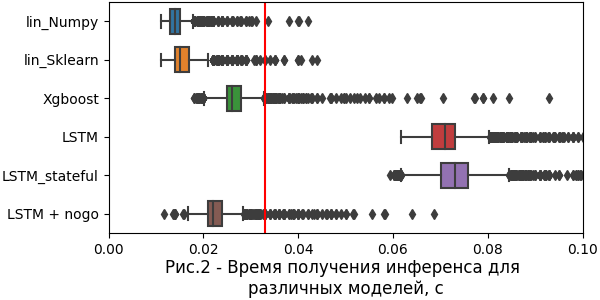

In [332]:
# Загрузка сохраненного списка
times =  pd.read_csv(os.path.join(PATH, 'times.csv'), index_col=0) 
#times['new_stateful'] = ts_list[:7244]

times = times.rename(columns={
    'manual_reg':'lin_Numpy', 
    'Lin_reg':'lin_Sklearn', 
    'xgb':'Xgboost', 
    'LSTM': 'LSTM', #'нейросеть BN + LSTM(100) + d/o', 
    'model_stateful':'LSTM_stateful'
})

fig, ax = plt.subplots(1,1, figsize=(6,3))
fig = sns.boxplot(data=times, orient='h', width=0.65)
ax.set_xlim(0,0.1)
ax.axvline(0.033, color='r')#, color='r', ls=':')
ax.set_title('Рис.2 - Время получения инференса для \nразличных моделей, c', y=-0.3)
plt.tight_layout(pad=0.15);
#plt.subplots_adjust(right=1.1)

plt.savefig(f'../figures/fig_2.png')

times.agg(['mean','std']).round(3)*1000

In [800]:
# Проверка совпадений номеров предсказаний, которые предсказываются дольше 33 мс
# times[(times['xgb']>0.033) & (times['Lin_reg']>0.033)][['xgb','xgb1']]

,xgb,xgb1


## Inference

### Offline (dataset)

In [360]:
df_sim = gestures_test.iloc[2000:2500]  
print(df_sim.shape)

TIMEOUT = 1 # 0.33
DEBUG = True
    
i = 0
ts_diff = 0

buff = np.zeros((6,50))
buff_pred = np.zeros((2,5))
ts_old = time.time()
y_previous = None
x_previous = np.zeros((5))

y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}

# # loading linear regression model
# with open(os.path.join(config.PATH_MODEL+'lin.pkl'), 'rb') as f:
#     saved_model = pickle.load(f)


# # loading xgb model
# with open(os.path.join(config.PATH_MODEL+'xgb.pkl'), 'rb') as f:
#     model_xgb = pickle.load(f)

saved_model = tf.keras.models.load_model(os.path.join(config.PATH_MODEL, 'model_LSTM'))

# # -----Модель Logistic regression--------
with open(os.path.join(config.PATH_MODEL+'log_reg.pkl'), 'rb') as f:
    log_reg = pickle.load(f)


while True:    
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
        
    # [Data preprocessing]
    sample_preprocessed, buff = preprocessing(omg_sample)
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed, saved_model)
    
    # inference for manual linear regression
    #y_predicted = get_predict(sample_preprocessed, weights)
  
    # [Inference Postprocessing]
    y_postprocessed      = postprocessing(y_predicted, prev=y_previous) #, preproc_coef=0.2
  
    # [Commands composition]
    #y_commands          = commands(y_postprocessed)
    y_commands          = commands_new(y_postprocessed, x_previous, sample_preprocessed, model=log_reg) #y_postprocessed
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)

    y_previous = y_postprocessed
    x_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1

SAMPLE SIZE: 65, OMG: 50, ACC: 6, ENCODERS: 6
BUTTON: 0, SYNC: 256, TS: 2213631


#### Сохранение списка из "комманд" различных моделей для сравнения с таргетом

In [464]:
#commands = dict()
#commands_df['LSTM']=pd.DataFrame({'LSTM':np.array(y_dct['y_commands']).flatten()})

#commands_df.head(2)

#commands_df.to_csv('../data/commands.csv')

,Xgboost,lin_Sklearn,lin_Numpy,LSTM
0,67,68,71,78
1,73,75,77,80


In [260]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (2500, 50)
enc_sample.shape = (2500, 6)
sample_preprocessed.shape = (2500, 100)
y_predicted.shape = (2500, 5)
y_postprocessed.shape = (2500, 5)
y_commands.shape = (2500, 5)


In [379]:
np.unique(np.round(np.clip(NEW, 0, 100)))#.astype(int)) 

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 39., 40.,
       41., 42., 43., 45., 46., 50., 51., 52., 53., 54., 55., 56., 57.,
       58., 59., 60., 61., 62., 63., 64., 65., 66., 68., 69., 71., 72.,
       73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84., 85.,
       86., 87., 88., 89., 90., 91., 92., 93., 94.])

In [367]:
temp=commands_df
temp['NEW'] = pd.DataFrame({'NEW':np.round(np.clip(NEW.flatten(), 0, 100))})

In [368]:
temp[['LSTM', 'NEW']].nunique()

LSTM    90
NEW     87
dtype: int64

In [274]:
# Чтение списка комманд
commands_df =  pd.read_csv(os.path.join(PATH, 'commands.csv'), index_col=0) 

lin_Numpy = commands_df['lin_Numpy'].values.reshape(500,5)
lin_Sklearn = commands_df['lin_Sklearn'].values.reshape(500,5)
Xgboost = commands_df['Xgboost'].values.reshape(500,5)
LSTMs = commands_df['LSTM'].values.reshape(500,5)


In [336]:
# Analysis of a new commands data
NEW = np.array(y_dct['y_commands'])

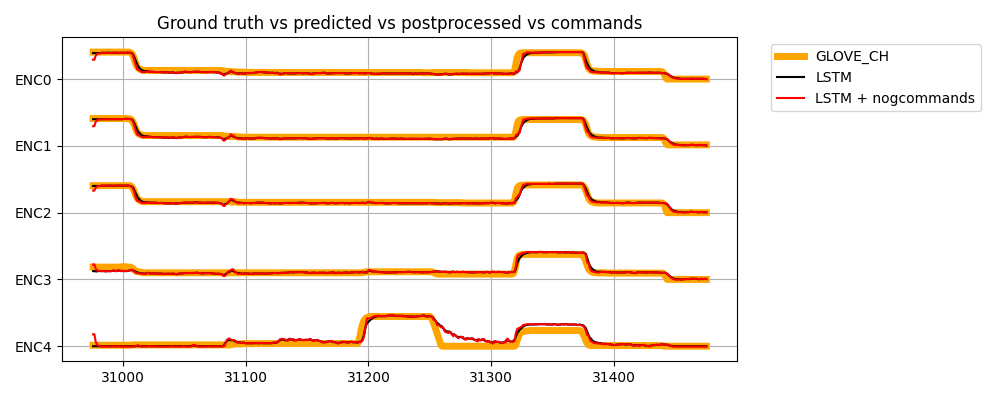

In [369]:
xticks = df_sim[GLOVE_CH].index
dist = -np.arange(len(GLOVE_CH)) * 200

fig, ax = plt.subplots(1, 1,  figsize=(10, 4))

ax.plot(xticks, df_sim[GLOVE_CH] + dist, c='orange', label='GLOVE_CH',linewidth=5)#, label='GLOVE_CH'
#ax.plot(xticks, lin_Numpy + dist, c='C1', label='lin_Numpy')#
#ax.plot(xticks,  lin_Sklearn + dist, c='C2', label='lin_Sklearn') #
#ax.plot(xticks,   Xgboost + dist, c='blue', label ='Xgboost') #
ax.plot(xticks,   LSTMs + dist, c='k', label ='LSTM')
ax.plot(xticks,   NEW + dist, c='red', label ='LSTM + nogo commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(dist, GLOVE_CH)

# get unique labels
handles, labels = plt.gca().get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
ax.legend(handles, labels, bbox_to_anchor=[1.04, 1]) 

plt.grid()
plt.tight_layout()

#plt.savefig(f'../figures/fig_4.png')

### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 